In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Model

In [ ]:
# Define the Custom CNN
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 24 * 24, 32)  # Adjust dimensions after pooling
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Load Data

In [3]:
# Transformations for STL-10 dataset
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize to higher resolution
    transforms.ToTensor(),       # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load STL-10 dataset
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100.0%


Extracting ./data\stl10_binary.tar.gz to ./data
Files already downloaded and verified


### Train and Test

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, Loss, Optimizer
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train_model_with_loss_plot(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

# Testing Loop
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

# Train and Evaluate
train_losses, val_losses = train_model_with_loss_plot(model, train_loader, test_loader, criterion, optimizer, num_epochs=20)
test_model(model, test_loader)

Epoch [1/20], Train Loss: 1.9878, Val Loss: 1.7997
Epoch [2/20], Train Loss: 1.7037, Val Loss: 1.6040
Epoch [3/20], Train Loss: 1.5136, Val Loss: 1.5162
Epoch [4/20], Train Loss: 1.3963, Val Loss: 1.4798
Epoch [5/20], Train Loss: 1.3004, Val Loss: 1.3862
Epoch [6/20], Train Loss: 1.1819, Val Loss: 1.3808
Epoch [7/20], Train Loss: 1.0815, Val Loss: 1.3737
Epoch [8/20], Train Loss: 0.9593, Val Loss: 1.3976
Epoch [9/20], Train Loss: 0.8390, Val Loss: 1.3863
Epoch [10/20], Train Loss: 0.7592, Val Loss: 1.3800
Epoch [11/20], Train Loss: 0.6585, Val Loss: 1.5968
Epoch [12/20], Train Loss: 0.5760, Val Loss: 1.5220
Epoch [13/20], Train Loss: 0.4643, Val Loss: 1.7035
Epoch [14/20], Train Loss: 0.3813, Val Loss: 1.7389
Epoch [15/20], Train Loss: 0.2983, Val Loss: 1.8120
Epoch [16/20], Train Loss: 0.2564, Val Loss: 1.9823
Epoch [17/20], Train Loss: 0.1912, Val Loss: 2.1012
Epoch [18/20], Train Loss: 0.1629, Val Loss: 2.1468
Epoch [19/20], Train Loss: 0.1052, Val Loss: 2.4247
Epoch [20/20], Train 

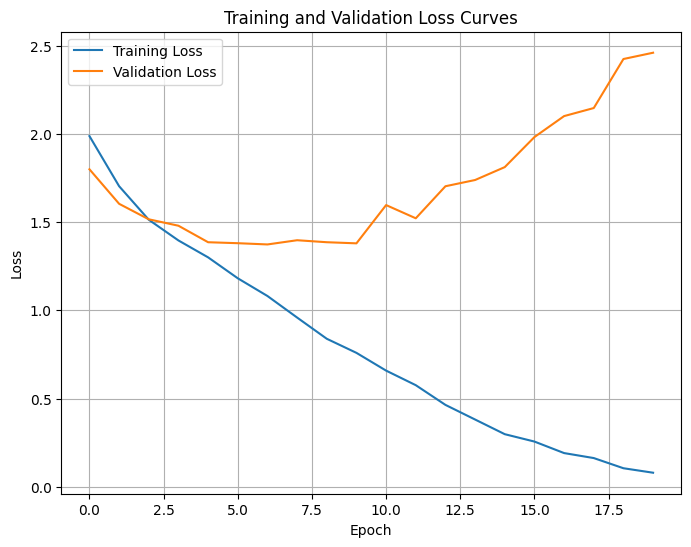

In [14]:
# Function to plot the loss curves
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the curves
plot_loss_curves(train_losses, val_losses)


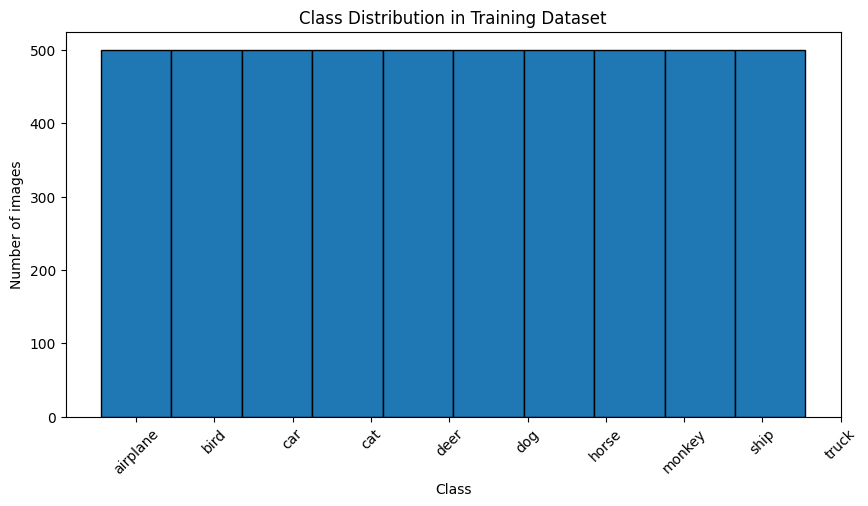

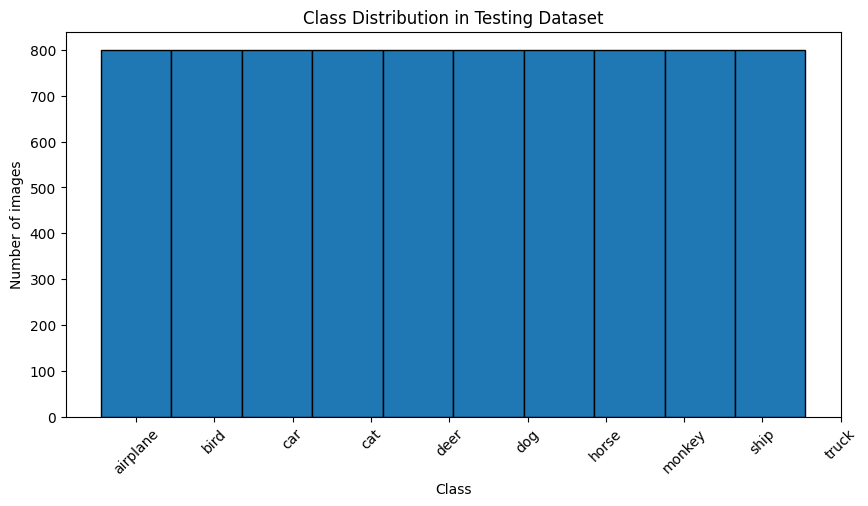

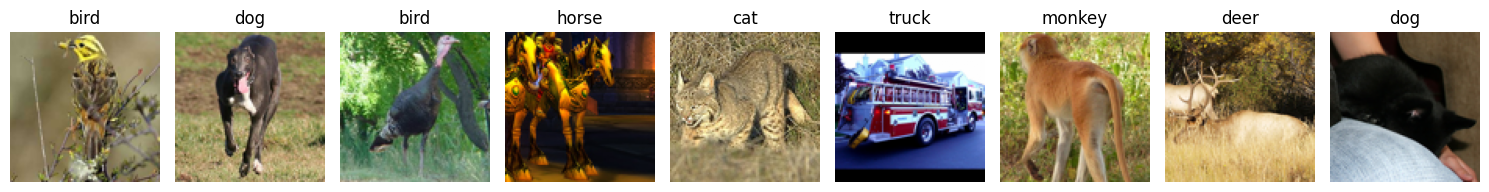

In [ ]:
import matplotlib.pyplot as plt

# Class labels for STL-10
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

# Function to display a grid of images
def show_images(dataset, num_images=9):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Select a random image
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # De-normalize to [0, 1] range
        
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(classes[label])
    plt.tight_layout()
    plt.show()

# Plot class distribution for training and testing datasets
show_images(train_dataset, num_images=9)